In [125]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
#values are taken from DESI 2024 VI: Cosmological Constraints.. 
w0_mean = -0.827
w0_sigma = 0.0632
wa_mean =  0.75
wa_sigma = 0.272
#correlation value assumed from Planck 2018
p = -0.83

#variances on the diagonal of cov matrix 
cov_00 = w0_sigma**2 
cov_11 = wa_sigma**2  
#covariances on off-diagonal of cov matrix 
cov_01 = p * w0_sigma * wa_sigma 

#covariance matrix is symmetric
cov_10 = cov_01 
cov_matrix = np.array([
    [cov_00, cov_01], 
    [cov_10, cov_11]])

In [127]:
#mean vector
#the mean vector is the center of the 2D Gaussian distribution
mu = np.array([w0_mean, wa_mean])

#grid of points for the contour plot of 2D Gaussian distribution defined by the mean vector and covariance matrix
#grid covers a range around the mean, scaled by the standard deviations, set to cover 5 standard deviations in each direction
#500 values between muw0 +/- 5*sigmaw0 and muwa +/- 5*sigmawa
#99.99994% of the probability mass is within +/- 5σ
x = np.linspace(mu[0] - 5*w0_sigma, mu[0] + 5*w0_sigma, 500)
y = np.linspace(mu[1] - 5*wa_sigma, mu[1] + 5*wa_sigma, 500)
#create a meshgrid for the contour plot
#2D arrays X/Y = coordinates for the grid points (X = w0, Y = wa)
X, Y = np.meshgrid(x, y)

#calculate the 2D Gaussian distribution values for each point in the grid using the multivariate normal distribution formula
#the formula is: P(x) = (1 / (2 * pi * sqrt(det(cov)))) * exp(-0.5 * (x - mu).T @ inv(cov) @ (x - mu))
from scipy.stats import multivariate_normal
#np.dstack combines X and Y into a 2D array where each row is a point (w0, wa)
#so position[i, j] = [X[i,j], Y[i,j]]
#function from scipy.stats computes the value of the gaussian probability distribution function at each point in that array
Z = multivariate_normal.pdf(np.dstack((X, Y)), mean=mu, cov=cov_matrix) 


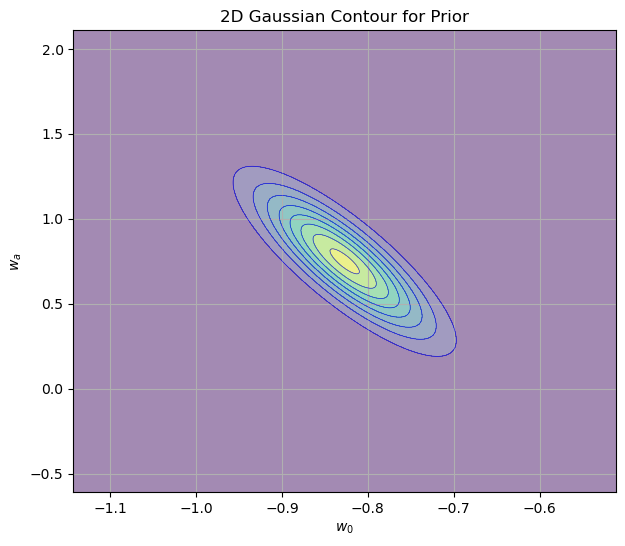

In [128]:
#plot the contour lines of the 2D Gaussian distribution
plt.figure(figsize=(7,6))
#each contour line encloses region of constant probability density
#uncertainty in each parameter = how wide the ellipse is 
#correlation between parameters = ellipse angle
#if negatively correlated = ellipses tilt downward
contour = plt.contourf(X, Y, Z, levels=10, alpha=0.5)
contourx = plt.contour(X, Y, Z, levels=10, colors='blue', linewidths=0.5, alpha=0.8)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title("2D Gaussian Contour for Prior")
plt.grid(True)
plt.show()

In [129]:
#importing chi2 from scipy.stats to calculate the levels for the contour plot
from scipy.stats import chi2

#ensuring that the 5*sigma ecllipse is captured in the plot by using a larger range
#the range is set to cover 8*sigma in each direction, which captures 99.9999994% of the probability mass 
x1 = np.linspace(w0_mean - 8*w0_sigma, w0_mean + 8*w0_sigma, 500)
y1 = np.linspace(wa_mean - 8*wa_sigma, wa_mean + 8*wa_sigma, 500)
#creating a new meshgrid for the larger range - defines the parameter space for plot 
X1, Y1 = np.meshgrid(x1, y1)
#2D gaussian distribution values for the new grid using the same mean vector and covariance matrix as before
Z1 = multivariate_normal.pdf(np.dstack((X1, Y1)), mean=mu, cov=cov_matrix) 

#finding the chi squared values for the confidence regions 
#converts confidence levels to chi-squared values for 2 degrees of freedom (2D = w0 and wa)
#ppf = inverse CDF (percent point function) for chi-squared distribution (what chi squared value gives x% confidence?)
#inputting confidence levels for 1σ, 2σ, 3σ, 4σ, and 5σ 
#converts to chi squared treshholds (|x-mu|^2 / sigma^2) < chi2_value = Mahalanobis Radius
chi2_values = chi2.ppf([0.683, 0.954, 0.997, 0.99994, 0.9999994], df=2) 

#convert chi sqaured region to PDF levels = height, using: level = peak * exp(-0.5 * chi2)
#works because multivariate Gaussian PDF falls off exponentially from the peak
#at distance sqrt(chi2) from the mean, the PDF value is reduced by a factor of exp(-0.5 * chi2) from peak value = f_peak 
f_peak = multivariate_normal(mean=mu, cov=cov_matrix).pdf(mu)
levels1 = f_peak * np.exp(-0.5 * chi2_values)
levels = sorted(levels1)

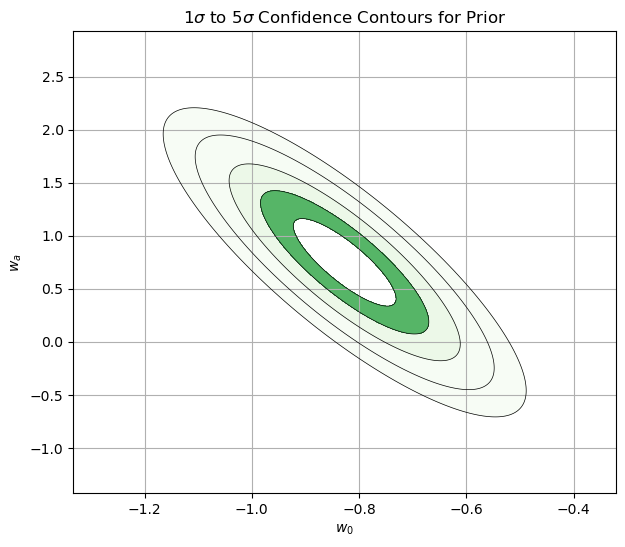

In [130]:
#plotting the contour again with the new levels - this time for 1σ to 5σ confidence contours 
plt.figure(figsize=(7,6))
contour1 = plt.contourf(X1, Y1, Z1, levels=levels, cmap='Greens')
contour2 = plt.contour(X1, Y1, Z1, levels=levels, colors='black', linewidths=0.5)

#setting the labels and title for the plot
plt.xlabel('$w_0$')
plt.ylabel('$w_a$')
plt.title('1$\sigma$ to 5$\sigma$ Confidence Contours for Prior')
plt.grid(True)

In 1D (w0 and wa separately):

In [323]:
from scipy.optimize import minimize_scalar

#same formulas from lab code 
#compute the posterior width from prior and likelihood widths using the Gaussian product formula
def new_sig(sig1, sig2):
    return 1 / np.sqrt(1/sig1**2 + 1/sig2**2)

#finding the mean of the posterior 
def new_mean(sig1, sig2, alpha):
    return (alpha * sig1) / (1 + (sig2**2 / sig1**2))

#tension: how far the posterior mean is from the prior mean, measured in units of posterior std
#tension T = posterior mean / posterior std 
def posterior_tension(sig1, sig2, alpha):
    return new_mean(sig1, sig2, alpha) / new_sig(sig1, sig2)

#inverting the process: we want to find the value of sigma2 that gives us a posterior tension T close to target tension 
#cant solve algebraically, so we use numerical optimization to find the value of sigma2 that minimizes the difference
#between the posterior tension and the target tension - using scipy's minimize_scalar function
#function tries many values and finds the value of sigma2 that gives us a posterior tension close to target_t 
def find_sigma2_for_T(sig1, alpha, target_t):
    def objective(sig2):
        T = posterior_tension(sig1, sig2, alpha)
        #minimising the absolute difference between posterior tension and target tension
        return abs(T - target_t)
    #guess for sigma2 in bounds to start, adjusts until the difference is small enough (1e-5) = numerical root finding
    result = minimize_scalar(objective, bounds=(1e-5, 1.0), method='bounded')
    return result.x if result.success else None

#using the w0 prior standard deviation as sig1 
sig1 = 0.0632
#want posterior mean to be 5 sigmas from 0
target_t = 5 

sig2_w0 = []

for alpha in [1, 2, 3, 4, 5]:
    required_sig2 = find_sigma2_for_T(sig1, alpha, target_t)
    print(f"For alpha = {alpha}, required sigma2 = {required_sig2:.5f}")
    sig2_w0.append(required_sig2) 



For alpha = 1, required sigma2 = 0.01240
For alpha = 2, required sigma2 = 0.02367
For alpha = 3, required sigma2 = 0.03350
For alpha = 4, required sigma2 = 0.04208
For alpha = 5, required sigma2 = 0.04968


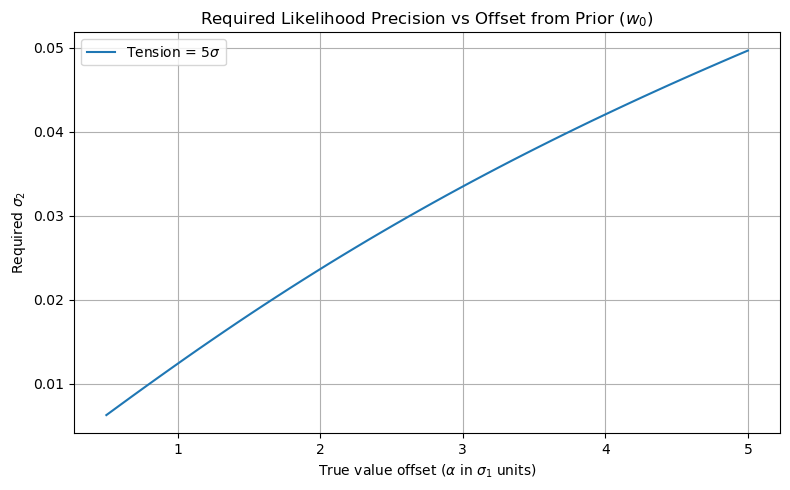

In [324]:
#using a finer range of alpha values
alphas = np.linspace(0.5, 5, 50)
#calculating the required sigma2 for each alpha value using a loop 
sigma2s = [find_sigma2_for_T(sig1, alpha, target_t) for alpha in alphas]

#plotting the required likelihood precision vs offset from prior
plt.figure(figsize=(8,5))
plt.plot(alphas, sigma2s, label=f'Tension = {target_t}$\sigma$')
plt.xlabel(r'True value offset ($\alpha$ in $\sigma_1$ units)')
plt.ylabel(r'Required $\sigma_2$')
plt.title('Required Likelihood Precision vs Offset from Prior ($w_0$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [328]:
#using the wa prior standard deviation as sig1 
sig1_2 = 0.272
#want posterior mean to be 5 sigmas from 0
target_t = 5 

sig2_wa = []

for alpha in [1, 2, 3, 4, 5]:
    required_sig2_2 = find_sigma2_for_T(sig1_2, alpha, target_t)
    print(f"For alpha = {alpha}, required sigma2 = {required_sig2_2:.5f}")
    sig2_wa.append(required_sig2_2)


For alpha = 1, required sigma2 = 0.05338
For alpha = 2, required sigma2 = 0.10189
For alpha = 3, required sigma2 = 0.14419
For alpha = 4, required sigma2 = 0.18112
For alpha = 5, required sigma2 = 0.21383


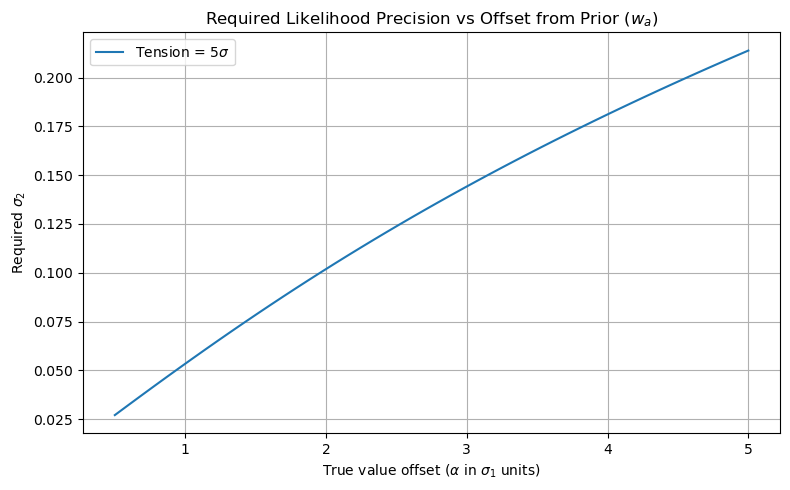

In [329]:
#calculating the required sigma2 for each alpha value using a loop 
sigma2s_2 = [find_sigma2_for_T(sig1_2, alpha, target_t) for alpha in alphas]

#plotting the required likelihood precision vs offset from prior
plt.figure(figsize=(8,5))
plt.plot(alphas, sigma2s_2, label=f'Tension = {target_t}$\sigma$')
plt.xlabel(r'True value offset ($\alpha$ in $\sigma_1$ units)')
plt.ylabel(r'Required $\sigma_2$')
plt.title('Required Likelihood Precision vs Offset from Prior ($w_a$)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Can see that towards left of curve, need very precise experiments (small sigma) if the true value is close to the prior. As the true value deviates more from the prior, the std (sigma 2) can be larger to produce the same tension value (T). 

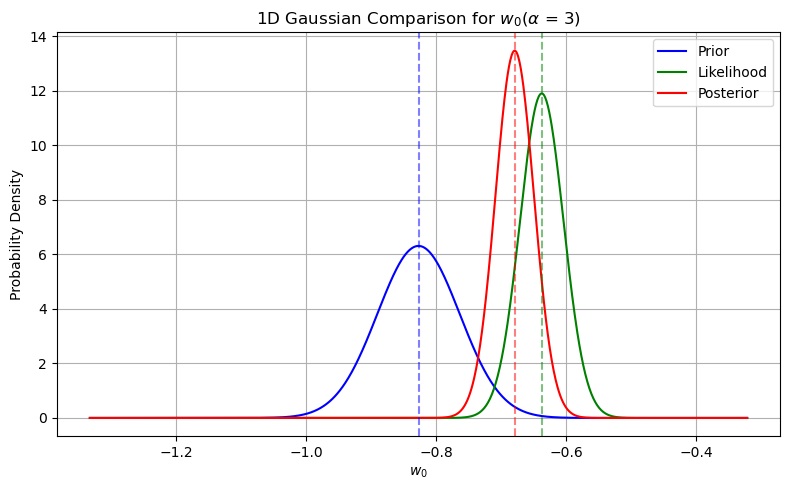

In [347]:
from scipy.stats import norm

#choosing an alpha value for the 1D Gaussian comparison 
alpha = 3
#extracting the required sigma2 for the chosen alpha
sigma2_w0 = sig2_w0[alpha - 1]

#extracting the prior value for w0 and its standard deviation 
mu_prior = mu[0] 
sigma1 = np.sqrt(cov_matrix[0, 0])

#finding the mean of the likelihood (alpha std away)
mu_like = mu_prior + alpha * sigma1

#finding the posterior mean and std for w0 (1D) - using the gaussian product formula 
var_post = 1 / (1/sigma1**2 + 1/sigma2_w0**2)
mu_post = var_post * (mu_prior/sigma1**2 + mu_like/sigma2_w0**2)
sigma_post = np.sqrt(var_post)

#plotting the range for comparison 
x = np.linspace(mu_prior - 8*sigma1, mu_prior + 8*sigma1, 1000)

#plotting 1D gaussians using scipy's norm.pdf for prior, likelihood, and posterior 
plt.figure(figsize=(8, 5))
plt.plot(x, norm.pdf(x, mu_prior, sigma1), 'b-', label='Prior')
plt.plot(x, norm.pdf(x, mu_like, sigma2_w0), 'g-', label='Likelihood')
plt.plot(x, norm.pdf(x, mu_post, sigma_post), 'r-', label='Posterior')

#indicating the means of the prior, likelihood, and posterior with dashed lines
plt.axvline(mu_prior, color='blue', linestyle='--', alpha=0.5)
plt.axvline(mu_like, color='green', linestyle='--', alpha=0.5)
plt.axvline(mu_post, color='red', linestyle='--', alpha=0.5)

plt.title(fr'1D Gaussian Comparison for $w_0 (\alpha$ = {alpha})')
plt.xlabel(r'$w_0$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


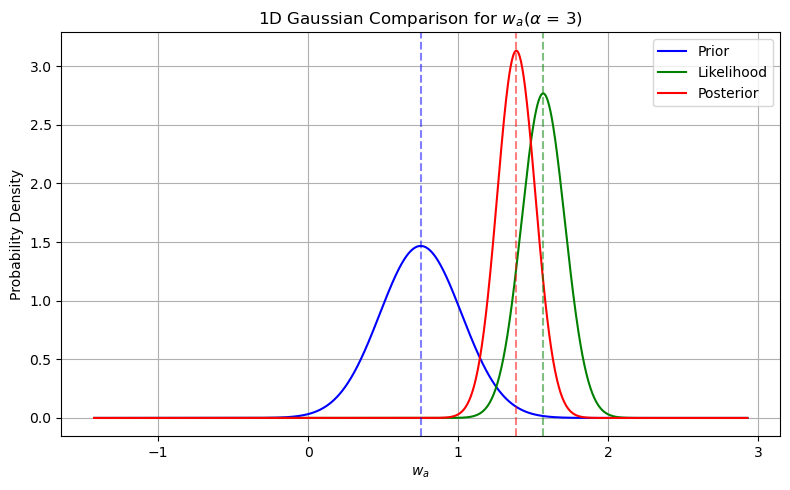

In [350]:
#extracting the required sigma2 for the chosen alpha
sigma2_wa = sig2_wa[alpha - 1]

#extracting the prior value for w0 and its standard deviation 
mu_prior = mu[1] 
sigma1 = np.sqrt(cov_matrix[1, 1])

#finding the mean of the likelihood (alpha std away)
mu_like = mu_prior + alpha * sigma1

#finding the posterior mean and std for wa (1D) - using the gaussian product formula 
var_post = 1 / (1/sigma1**2 + 1/sigma2_wa**2)
mu_post = var_post * (mu_prior/sigma1**2 + mu_like/sigma2_wa**2)
sigma_post = np.sqrt(var_post)

#plotting the range for comparison 
x = np.linspace(mu_prior - 8*sigma1, mu_prior + 8*sigma1, 1000)

#plotting 1D gaussians using scipy's norm.pdf for prior, likelihood, and posterior 
plt.figure(figsize=(8, 5))
plt.plot(x, norm.pdf(x, mu_prior, sigma1), 'b-', label='Prior')
plt.plot(x, norm.pdf(x, mu_like, sigma2_wa), 'g-', label='Likelihood')
plt.plot(x, norm.pdf(x, mu_post, sigma_post), 'r-', label='Posterior')

#indicating the means of the prior, likelihood, and posterior with dashed lines
plt.axvline(mu_prior, color='blue', linestyle='--', alpha=0.5)
plt.axvline(mu_like, color='green', linestyle='--', alpha=0.5)
plt.axvline(mu_post, color='red', linestyle='--', alpha=0.5)

plt.title(fr'1D Gaussian Comparison for $w_a (\alpha$ = {alpha})')
plt.xlabel(r'$w_a$')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In 2D: 

In [244]:
#given two Gaussian distributions (prior and likelihood), finding the posterior mean and covariance
#using bayesian conjuate formulas (bayesian update rules)
#posterior covariance is given by the formula: cov_post = (cov1^-1 + cov2^-1)^-1
#posterior mean is given by the formula: mu_post = cov_post * (cov1^-1 * mu1 + cov2^-1 * mu2)

#mu1 and cov1 are the mean and covariance of the prior distribution
#mu2 and cov2 are the mean and covariance of the likelihood distribution
#returns the posterior mean and covariance
def find_posterior(mu1, cov1, mu2, cov2):
    #obtaining the inverse of the covariance matrices since we need the precision matrices
    #covariance matrix is symmetric, so use np.linalg.inv to compute the inverse 
    inv1 = np.linalg.inv(cov1)
    inv2 = np.linalg.inv(cov2)
    #posterior covariance is the inverse of the sum of the precision matrices
    #reflects that adding additional information (likelihood) reduces uncertainty
    #so posterior variance is lower than prior/likelihood variance
    cov_post = np.linalg.inv(inv1 + inv2)
    #posterior mean is the weighted sum of the prior and likelihood means, weighted by their precisions 
    #reflects that the posterior mean is a compromise between the prior and likelihood means
    #if likelihood is more precise (smaller cov2), its mean pulls the posterior toward it etc. 
    mu_post = cov_post @ ((inv1 @ mu1) + (inv2 @ mu2))
    return mu_post, cov_post

In [245]:
#Mahalanobis distance = multivariate generalisation of a z-score
#measures how far two vectors are from each other, taking into account their uncertainty

#function to calculate the Mahalanobis tension between posterior and prior means
#Mahalanobis tension is a measure of how far the posterior mean is from the prior mean, normalized by the posterior covariance
#posterior tension is measured in units of the posterior standard deviation (uncertainty) 
#the formula is: T = sqrt((mu_post - mu_prior)^T * inv(cov_post) * (mu_post - mu_prior))
#generalisation of T = mu_post / sigma_post, where sigma_post is the posterior standard deviation 
def mahalanobis_tension(mu_post, mu_prior, cov_post):
    #difference between posterior and prior means
    delta = mu_post - mu_prior
    #inverse of the posterior covariance matrix 
    #distance is scaled by the uncertainty in each direction (precision matrix) - weighted 
    #if posterior covariance is very small in a direction = the same shift counts for more
    #if posterior covariance is large in a direction = the same shift counts for less
    inv_cov = np.linalg.inv(cov_post)
    #calculating the mahalanobis tension using the formula
    #this scalar is the squared distance between the posterior and prior means, scaled by the posterior covariance
    #taking the square root gives the Mahalanobis tension value 
    #.item() extracts a python scalar from a 0-d array - need tension to be a scalar value, not an array 
    tension = np.sqrt(delta.T @ inv_cov @ delta).item()
    #returning the mahalanobis tension value
    return tension


In [252]:
from scipy.optimize import minimize

#function to calculate the likelihood covariance that gives a desired posterior tension
#mu_prior is the prior mean vector, cov_prior is the prior covariance matrix
#alpha is the offset from the prior mean in units of the prior standard deviation
#target_T is the desired posterior tension
def likelihood_cov_for_tension(mu_prior, cov_prior, alpha, row, target_T):
    #obtaining the prior standard deviation vector from the covariance matrix
    #the standard deviation vector is the square root of the diagonal elements of the covariance matrix 
    #diagonal elements of the cov matrix = variances of w0 and wa 
    sigma_prior_vec = np.sqrt(np.diag(cov_prior))
    #the likelihood mean is the prior mean plus an offset in units of the prior standard deviation
    #shifts the mean by alpha std in each direction - models future measurement that is offset from the prior
    mu_like = mu_prior + alpha * sigma_prior_vec
    
    #log_sigmas = 2 element array of log std for likelihood (w0, wa) 
    #optimise over the log of the standard deviations to ensure positivity in the std
    def objective(log_sigmas):
        #convert log standard deviations back to standard deviations 
        sig2 = np.exp(log_sigmas)
        #building a diagonal covariance matrix for the likelihood - assuming w0 and wa have same correlation as the prior 
        #squaring the std to get variances for the likelihood covariance matrix 
        cov_like = np.array([
            [sig2[0]**2, row * sig2[0] * sig2[1]],
            [row * sig2[0] * sig2[1], sig2[1]**2] ])
        #finding what posterior mean and covariance would be if likelihood has sig2 and centered at mu_like 
        mu_post, cov_post = find_posterior(mu_prior, cov_prior, mu_like, cov_like)
        #computing the mahalanobis tension between the posterior and prior means, in units of the posterior std
        #tells how surprising the posterior mean is given the prior and likelihood
        t = mahalanobis_tension(mu_post, mu_prior, cov_post)
        #returning the squared difference between the posterior tension and the target tension 
        #optimiser will try to minimize this difference, when t = target_t, the objective function will be 0 
        return (t - target_t)**2

    #initial guess for the log standard deviations of the likelihood, using the prior standard deviations 
    #so guess = [log (std_w0), log (std_wa)] 
    guess = np.log(sigma_prior_vec) 
    #running the optimization to find the log standard deviations that give the desired posterior tension
    #objective = function to minimize, guess = initial guess for the log standard deviations
    #method='L-BFGS-B' is a quasi-newton method for bound-constrained optimization, works well for low dimensional problems
    result = minimize(objective, guess, method='L-BFGS-B')
    #convert the optimized log standard deviations back to standard deviations
    #returns the best value estimates for log_sigmas and whether the optimization was successful 
    return np.exp(result.x) if result.success else None


In [271]:
#5 std away from prior = good benchmark for tension 
target_t = 5
#correlation between w0 and wa, assumed from Planck 2018
row = -0.83
#list of alphas to test - how far the future measurement is from the prior mean in units of the prior std
alphas1 = [1, 2, 3, 4, 5]

#if a future survey measures w0/wa to be alpha std away from prior,
#how precise must that survey be for the posterior to show a 5σ shift (tension) from the prior?? - the question to answer 

#setting up the table header for the output
print("Required Likelihood Covariance for Tension") 
print(f"{'alpha':<8}{'sigma_2,w0':<15}{'sigma_2,wa':<15}")
sigma2s = []
#looping over the alpha values 
for alpha in alphas1:
    #calling the function to find the required likelihood covariance for the given alpha and target tension
    #mu is the prior mean vector, cov_matrix is the prior covariance matrix
    #alpha is the offset from the prior mean in units of the prior standard deviation
    #returns the required stds for the likelihood covariance that gives target_t tension
    required_sigmas = likelihood_cov_for_tension(mu, cov_matrix, alpha, row, target_t)
    #checking if the optimization was successful and printing the results 
    if required_sigmas is not None:
        print(f"{alpha:<8}{required_sigmas[0]:<15.10f}{required_sigmas[1]:<15.10f}")
        sigma2s.append(required_sigmas) 
    else:
        print(f"{alpha:<8}optimization failed")


Required Likelihood Covariance for Tension
alpha   sigma_2,w0     sigma_2,wa     
1       0.0373294681   0.1606584747   
2       0.0619314212   0.2665402962   
3       0.0803871040   0.3459698067   
4       0.0956214613   0.4115348434   
5       0.1088476401   0.4684581961   


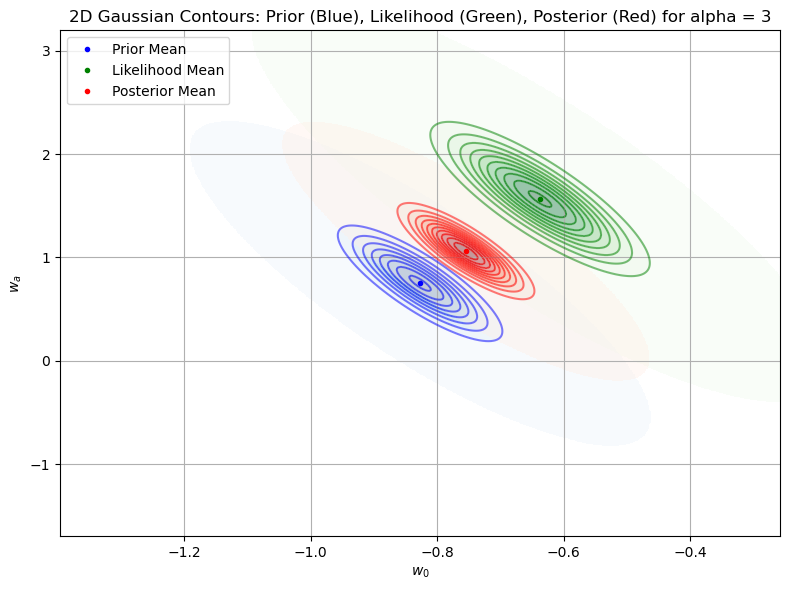

In [313]:
from scipy.stats import multivariate_normal

# Step 1: Define means and covariances
mu_prior = mu  # already defined
cov_prior = cov_matrix

# Define your alpha (offset in σ units from prior)
alpha = 3
sigma_prior_vec = np.sqrt(np.diag(cov_prior))
mu_like = mu_prior + alpha * sigma_prior_vec

# Likelihood covariance 
sigma_opt = sigma2s[alphas1.index(alpha)]
cov_like = np.array([
    [sigma_opt[0]**2, row * sigma_opt[0] * sigma_opt[1]],
    [row * sigma_opt[0] * sigma_opt[1], sigma_opt[1]**2]
])

# Step 2: Get posterior mean and covariance
mu_post, cov_post = find_posterior(mu_prior, cov_prior, mu_like, cov_like)

# Step 3: Set up meshgrid
x = np.linspace(mu_prior[0] - 9*sigma_prior_vec[0], mu_prior[0] + 9*sigma_prior_vec[0], 500)
y = np.linspace(mu_prior[1] - 9*sigma_prior_vec[1], mu_prior[1] + 9*sigma_prior_vec[1], 500)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Step 4: Evaluate the distributions
Z_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(pos)
Z_like = multivariate_normal(mean=mu_like, cov=cov_like).pdf(pos)
Z_post = multivariate_normal(mean=mu_post, cov=cov_post).pdf(pos)

# Step 5: Plot all three
plt.figure(figsize=(8, 6))
Z_prior[Z_prior < 1e-6] = np.nan
cp1 = plt.contourf(X, Y, Z_prior, levels=10, cmap='Blues', alpha=0.4)
Z_like[Z_like < 1e-6] = np.nan
cp2 = plt.contourf(X, Y, Z_like, levels=10, cmap='Greens', alpha=0.4)
Z_post[Z_post < 1e-6] = np.nan
cp3 = plt.contourf(X, Y, Z_post, levels=10, cmap='Reds', alpha=0.4)

cp11 = plt.contour(X, Y, Z_prior, levels=10, colors='blue', alpha=0.5)
cp21 = plt.contour(X, Y, Z_like, levels=10, colors='green', alpha=0.5)
cp31 = plt.contour(X, Y, Z_post, levels=10, colors='red', alpha=0.5)

# Plot means
plt.plot(*mu_prior, 'bo', label='Prior Mean', markersize=3)
plt.plot(*mu_like, 'go', label='Likelihood Mean', markersize=3)
plt.plot(*mu_post, 'ro', label='Posterior Mean', markersize=3)

# Labels and legend
plt.xlabel(r'$w_0$')
plt.ylabel(r'$w_a$')
plt.title('2D Gaussian Contours: Prior (Blue), Likelihood (Green), Posterior (Red) for alpha = 3') 
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [316]:
from scipy.stats import chi2

# Confidence levels for 1σ to 5σ
confidence_levels = [0.683, 0.954, 0.997, 0.99994, 0.9999994]  # up to ~5σ
chi2_vals = chi2.ppf(confidence_levels, df=2)

# Evaluate peaks at the mean
f_peak_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(mu_prior)
f_peak_like = multivariate_normal(mean=mu_like, cov=cov_like).pdf(mu_like)
f_peak_post = multivariate_normal(mean=mu_post, cov=cov_post).pdf(mu_post)

# Convert chi2 thresholds to PDF levels
levels_prior = sorted(f_peak_prior * np.exp(-0.5 * chi2_vals))
levels_like = sorted(f_peak_like * np.exp(-0.5 * chi2_vals))
levels_post = sorted(f_peak_post * np.exp(-0.5 * chi2_vals))


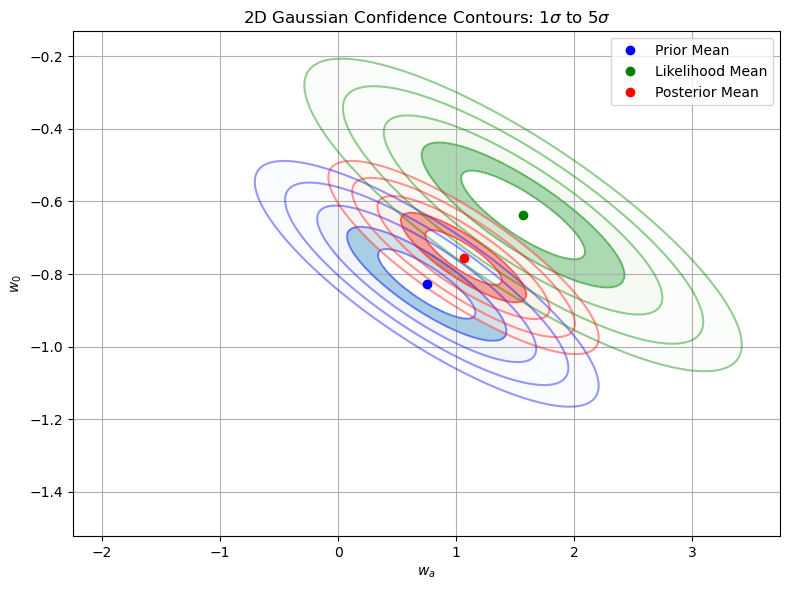

In [322]:
plt.figure(figsize=(8, 6))

# Use flipped axis (w0 on y, wa on x)
x = np.linspace(mu[1] - 11*sigma_prior_vec[1], mu[1] + 11*sigma_prior_vec[1], 500)  # wa
y = np.linspace(mu[0] - 11*sigma_prior_vec[0], mu[0] + 11*sigma_prior_vec[0], 500)  # w0
X, Y = np.meshgrid(x, y)
pos = np.dstack((Y, X))  # flipped: w0, wa

# Evaluate PDFs on grid
Z_prior = multivariate_normal(mean=mu_prior, cov=cov_prior).pdf(pos)
Z_like  = multivariate_normal(mean=mu_like,  cov=cov_like).pdf(pos)
Z_post  = multivariate_normal(mean=mu_post,  cov=cov_post).pdf(pos)

# Plot 1σ to 5σ contours using proper levels
plt.contour(X, Y, Z_prior, levels=levels_prior, colors='blue', alpha=0.4)
plt.contour(X, Y, Z_like,  levels=levels_like,  colors='green', alpha=0.4)
plt.contour(X, Y, Z_post,  levels=levels_post,  colors='red', alpha=0.4)

plt.contourf(X, Y, Z_prior, levels=levels_prior, cmap='Blues', alpha=0.5)
plt.contourf(X, Y, Z_like,  levels=levels_like,  cmap='Greens', alpha=0.5)
plt.contourf(X, Y, Z_post,  levels=levels_post,  cmap='Reds', alpha=0.5)


# Plot means
plt.plot(mu_prior[1], mu_prior[0], 'bo', label='Prior Mean')
plt.plot(mu_like[1],  mu_like[0],  'go', label='Likelihood Mean')
plt.plot(mu_post[1],  mu_post[0],  'ro', label='Posterior Mean')

# Axis labels
plt.xlabel(r'$w_a$')
plt.ylabel(r'$w_0$')
plt.title('2D Gaussian Confidence Contours: $1\sigma$ to $5\sigma$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
